<a href="https://colab.research.google.com/github/aquapathos/Demo/blob/master/MNIST%E3%81%AE%E6%89%8B%E6%9B%B8%E3%81%8D%E6%96%87%E5%AD%97%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E5%AD%A6%E7%BF%92%E3%81%A8%E8%AD%98%E5%88%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNISTの手書き文字の認識

MNISTの手書き文字の認識を

*   TensorFlow
*   Keras
*   Chainer    

で書いてみる．

データ構造については，[MNISTの手書き文字データ](https://github.com/aquapathos/Demo/blob/master/MNIST%E3%81%AE%E6%89%8B%E6%9B%B8%E3%81%8D%E6%96%87%E5%AD%97%E3%83%87%E3%83%BC%E3%82%BF.ipynb) を参照せよ．

## ライブラリのインポート



In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import keras
import chainer

Using TensorFlow backend.


## MNIST  手書き文字データセットの読み込み

#### 画像表示用関数を定義しておく

In [0]:
def plotchr(images,labels,categorical=False):
    sns.set_context("talk")   # "talk" はタイトルの文字サイズ。　paper <  notebook <  talk <  poster の順にフォントサイズが大きくなる
    low = (len(images)-1)//10+1
    for i,(image,label) in enumerate(zip(images,labels)):
        if categorical:
            label = np.argmax(label)
        image = image.reshape((28,28))
        plt.subplot(low,10,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title("%d" % label) # np.argmax は最大値のインデックスを求める関数．１はひとつしかないので，その位置がわかる．
        plt.imshow(image,cmap=plt.cm.gray_r)

### TensorFlow

W0618 17:03:40.959268 140596982585216 deprecation.py:323] From <ipython-input-4-f20be23afa66>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0618 17:03:40.960369 140596982585216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0618 17:03:40.961141 140596982585216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz


W0618 17:03:41.341569 140596982585216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0618 17:03:41.343963 140596982585216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W0618 17:03:41.424111 140596982585216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be remove

Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


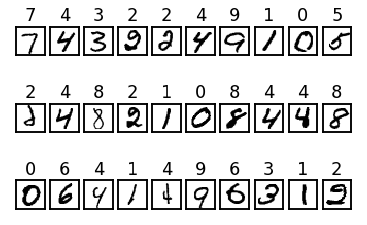

In [4]:
# tensorflow の場合のデータの読み込み方法
from tensorflow.examples.tutorials.mnist import input_data
mnistTF = input_data.read_data_sets("/tmp/data/", one_hot=True)
# TensorFlow
images, labels = mnistTF.train.images[100:130], mnistTF.train.labels[100:130]
plotchr(images,labels,categorical=True)

#### Keras

11493376/11490434 [==============================] - 0s 0us/step


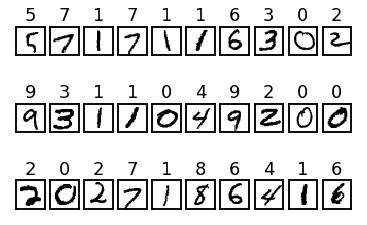

In [5]:
# keras の場合のデータの読み込み方法
from keras.datasets import mnist
(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()
# Keras
plotchr(Xtrain[100:130],ytrain[100:130],categorical=False)

### Chainer
Chainer のデータ読み込み関数は，引数  ndim で画像データの形式を1次元～3次元まで選択できる．ここでは1次元で読み込む例を示しておく．

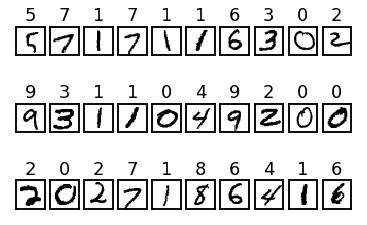

In [7]:
# chainer の場合のデータの読み込み方法
from chainer import datasets
trainC, testC = datasets.get_mnist(ndim=1)
imagesC = [image for (image,label) in trainC]
labelsC = [label for (image,label) in trainC]
plotchr(imagesC[100:130],labelsC[100:130],categorical=False) 

# モデル０　（いきなりsoftmax）

入力 x：784画素そのもの　＝　784のノード  
出力 y ：１ of 10 表現　＝　10のノード

モデル：隠れ層なし．入力と出力が全結合．softmax で最も出力の大きいカテゴリを正解とする．

その結合重みを Wとする．Wは （784ｘ10）の行列で表せる．

10個の出力ノードそれぞれへの入力の総和は784の入力と784の結合重みのテンソル積 x W で表現できる．

##TensorFlow 

まず，入力データを placeholder, 未知数である重みWとしきい値w0 を Variable と定義し，ニューロンの内部状態や出力をそれらの関係式として定義してやる．

In [0]:
# モデルの作成
x = tf.placeholder(tf.float32, [None, 784]) # データの入れ物，placeholder [データ数, 784] という配列 
W = tf.Variable(tf.zeros([784, 10])) # 出力が1つあたり，784の重みをもつ．重みは未知数．未知数は Variable 
w0 = tf.Variable(tf.zeros([10])) # w0 はいわゆるしきい値を表す変数．
f = tf.matmul(x,W)+w0 # ニューロンの内部状態を，全ニューロンまとめて記述したことになる．matmul は行列積
p = tf.nn.softmax(f) # 内部状態が10個計算されてくるが，それをソフトマックスで１つにしぼる．

次に，正解を入れるための placeholderを用意し，誤差関数を定義し，オプティマイザーを準備し，最適化ステップを定義する．

In [0]:
# 誤差関数と最適化器の定義
t = tf.placeholder(tf.float32, [None,10])
loss = -tf.reduce_sum(t * tf.log(p))   
optimizer = tf.train.AdamOptimizer()
train = optimizer.minimize(loss)

# 正解率の定義
correct_pred = tf.equal(tf.argmax(p,1),tf.argmax(t,1))   # 出力と正解が一致するかどうかの判定リスト　1 はどの次元を見るか．０はデータの次元なので１
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32)) # 真理値を浮動小数点化して平均をとる

 上のプログラムの，**a * b** という演算は要素ごとの積，**th.reduce_sum** は要素の和を意味するので，**th.reduce_sum(a * b)** は内積を意味する．
 
 ベクトル t の成分は正解の位置以外は０なので，p の成分の正解位置にあたる出力の対数の和を最小化する，という意味になる．softmax を通しているので，p の各成分は正で合計が１となっており，確率的な意味をもつ．ある問題の出力が完璧な場合は，正解位置がほぼ１になり，対数をとると０近い値になる．完璧に正解の成分のみが１で他が０ならば対数の値は０となり，正解すれば最小化され０となるような量である．

optimizer （最適化器）はさまざまなものが用意されている．**AdamOptimizer** は一般に，単純な勾配降下法より高速に最適解が求められるのでよく用いられる．


In [0]:
# セッションの初期化

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# 学習の実行

In [11]:
BATCH_SIZE = 100

for i in range(2001):
    batch_tx, batch_tl = mnistTF.train.next_batch(BATCH_SIZE)
    sess.run(train, feed_dict = {x: batch_tx, t: batch_tl})
    if i % 200 == 0:
        loss_val, acc_val = sess.run([loss, accuracy],
                                    feed_dict = {x:mnistTF.test.images, t: mnistTF.test.labels})
        print('Step:{0:5d}, Loss: {1:5.4f}, Accuracy: {2:5.4f}'.format(i, loss_val, acc_val))
        

Step:    0, Loss: 22595.5605, Accuracy: 0.2921
Step:  200, Loss: 5364.5283, Accuracy: 0.8774
Step:  400, Loss: 4080.8989, Accuracy: 0.8993
Step:  600, Loss: 3584.2334, Accuracy: 0.9074
Step:  800, Loss: 3356.8857, Accuracy: 0.9098
Step: 1000, Loss: 3165.2861, Accuracy: 0.9144
Step: 1200, Loss: 3071.0872, Accuracy: 0.9150
Step: 1400, Loss: 3004.8804, Accuracy: 0.9162
Step: 1600, Loss: 2954.8467, Accuracy: 0.9192
Step: 1800, Loss: 2931.8728, Accuracy: 0.9181
Step: 2000, Loss: 2848.1714, Accuracy: 0.9217


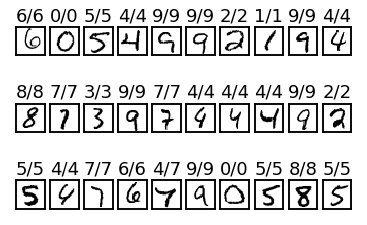

In [12]:
# 識別結果の確認

def plotchr2(images,labels,clabels, categorical=False):
    sns.set_context("talk")   # "talk" はタイトルの文字サイズ。　paper <  notebook <  talk <  poster の順にフォントサイズが大きくなる
    low = (len(images)-1)//10+1
    for i,(image,label,clabel) in enumerate(zip(images,labels,clabels)):
        if categorical:
            label = np.argmax(label)
            clabel = np.argmax(clabel)
        image = image.reshape((28,28))
        plt.subplot(low,10,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title("{}/{}".format(label,clabel)) # np.argmax は最大値のインデックスを求める関数．１はひとつしかないので，その位置がわかる．
        plt.imshow(image,cmap=plt.cm.gray_r)

images, labels = mnistTF.test.images[100:130], mnistTF.test.labels[100:130]
predict = sess.run(p, feed_dict = {x: images, t: labels})
plotchr2(images,predict,labels,categorical=True)


# Keras

In [0]:
# データ構造の変換
Xtrain = Xtrain.reshape(60000, 784) # 2次元配列を1次元に変換
Xtest = Xtest.reshape(10000, 784)

ytrain = keras.utils.to_categorical(ytrain, 10) # カテゴリカル表現に変換
ytest = keras.utils.to_categorical(ytest, 10)

Xtrain = Xtrain.astype('float32')   # int型をfloat32型に変換
Xtest = Xtest.astype('float32')
Xtrain /= 255                        # [0-255]の値を[0.0-1.0]に変換
Xtest /= 255

In [14]:
# モデルの構築
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers 

model = Sequential()
model.add(Dense(10, activation='softmax', input_shape=(784,)))   # <-  実質1行

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer = optimizers.Adam(),
              metrics=['accuracy'])

W0618 17:14:09.271225 140596982585216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 17:14:09.274958 140596982585216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 17:14:09.282386 140596982585216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 17:14:09.317811 140596982585216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0618 17:14:09.326701 140596982585216 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


# 学習の実行

In [15]:
# 学習
history = model.fit(Xtrain, ytrain,  # 画像とラベルデータ
                    batch_size=BATCH_SIZE,
                    epochs=1,     # エポック数の指定
                    verbose=1,         # ログ出力の指定. 0だとログが出ない
                    validation_data=(Xtest, ytest))

W0618 17:14:13.037921 140596982585216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0618 17:14:13.082199 140596982585216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s 36us/step - loss: 0.6176 - acc: 0.8450 - val_loss: 0.3599 - val_acc: 0.9071


In [16]:
# 認識率評価
score = model.evaluate(Xtest, ytest, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.35994955461025235
Test accuracy: 0.9071


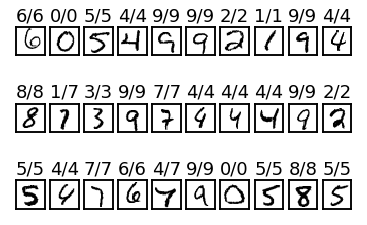

In [17]:
# 識別結果の確認
predict = model.predict(Xtest[100:130])
plotchr2(Xtest[100:130],predict,ytest[100:130],categorical=True)

# Chainer

TensorFlow と Keras はクラスを使わなかった（もちろん使うこともできる）が，Chainerはネットワークをまとめたものを Chain とよび，ネットワークを定義することは，Chain のサブクラスを定義することととらえているので，基本的にクラスを定義する必要があるようである．

機械学習では用意されている学習サンプルの一部を取り出しては学習し，取り出しては学習し，を繰り返す．この単位をバッチと呼ぶ．
Tensorflow ではバッチの取り出しをサポートする関数 next_batch が用意されているが，自分で定義しても構わない．
Keras ではバッチのサイズを指定するだけで，そのサイズで全学習サンプルを分割して全部学習すること＝エポックを学習の最小単位としている．
どのように学習サンプルを取り出すのかはブラックボックスであり，学習サンプルの半分だけ使う，といった自由度はない．
（半分だけ使うのなら，さいしょからそれを全学習データとすればいい）

Chainer の場合は，バッチデータを取り出す仕組みを Iterator とよび，これをユーザが定義する． 

In [19]:
import chainer.functions as F
import chainer.links as L
from chainer import training, Chain
import chainer.optimizers as optimizers
from chainer.datasets import split_dataset_random
from chainer.training import extensions

# 訓練データを学習用と検証用に分割する．
trainC, validC = split_dataset_random(trainC, 55000, seed=0)
print(len(trainC),len(validC))

from chainer import iterators

batchsize = 100
epoch = 10
frequency = -1

# イテレータを作る

train_iter = iterators.SerialIterator(trainC, batchsize)
valid_iter = iterators.SerialIterator(
    validC, batchsize, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(
    testC, batchsize, repeat=False, shuffle=False)

55000 5000


In [0]:
# CPUバージョン
# モデル定義
'''
class NN(Chain):
    def __init__(self):
        super(NN, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(784, 10)
            
    def __call__(self, x): 
        y = self.l1(x) # chainer の場合，ラストのSoftmax は不要
        return y

# 学習
modelC = L.Classifier(NN())
#chainer.cuda.get_device_from_id(0)
#modelC.to_gpu(-1)

optimizer = chainer.optimizers.Adam()
optimizer.setup(modelC)

#updater = training.StandardUpdater(train_iter, optimizer, device=0)
updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (epoch, 'epoch'))

#trainer.extend(extensions.Evaluator(test_iter, modelC,device=0))
trainer.extend(extensions.Evaluator(test_iter, modelC))
trainer.extend(extensions.dump_graph('main/loss'))

frequency = epoch if frequency == -1 else max(1, frequency)
trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))
trainer.extend(extensions.LogReport())
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# 学習実行
trainer.run()

from IPython.display import Image, display_png

display_png(Image('result/loss.png'))
display_png(Image('result/accuracy.png'))

# 識別結果の確認
images = np.array([image for (image,label) in testC[100:130]])
labels = np.array([label for (image,label) in testC[100:130]])
predict = [np.argmax(x) for x in modelC.predictor(images).data]
plotchr2(images,predict,labels,categorical=False)
'''

In [0]:
# GPU バージョン

from chainer import cuda

# モデル定義
class NNG(Chain):
    def __init__(self):
        super(NNG, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(784, 10)
            
    def __call__(self, x): 
        y = self.l1(x) # chainer の場合，ラストのSoftmax は不要
        return y
    
# 学習
modelG = L.Classifier(NNG())

cuda.get_device(0).use()
modelG.to_gpu(0)

optimizerG = chainer.optimizers.Adam()
optimizerG.setup(modelG)

updaterG = training.StandardUpdater(train_iter, optimizerG, device=0)
trainerG = training.Trainer(updaterG, (epoch, 'epoch'))

trainerG.extend(extensions.Evaluator(test_iter, modelG,device=0))
trainerG.extend(extensions.dump_graph('main/loss'))

frequency = epoch if frequency == -1 else max(1, frequency)
trainerG.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))
trainerG.extend(extensions.LogReport())
trainerG.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='lossG.png'))
trainerG.extend(
    extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracyG.png'))
trainerG.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

In [21]:
trainerG.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.642412    0.368953              0.846691       0.9051                    8.42151       
2           0.352043    0.313802              0.904219       0.9156                    10.5057       
3           0.312994    0.297145              0.913293       0.916                     12.6101       
4           0.294646    0.282969              0.91871        0.9217                    14.7332       
5           0.283923    0.274585              0.920729       0.9233                    16.8426       
6           0.276454    0.274025              0.923638       0.9237                    18.946        
7           0.270689    0.270768              0.925074       0.9233                    21.058        
8           0.266217    0.267775              0.926201       0.9251                    23.1388       
9           0.262881    0.267867              0.92711        0.9234                 

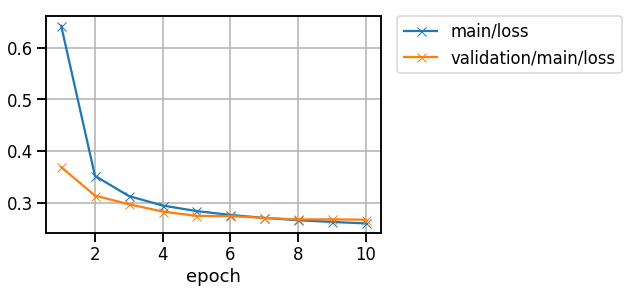

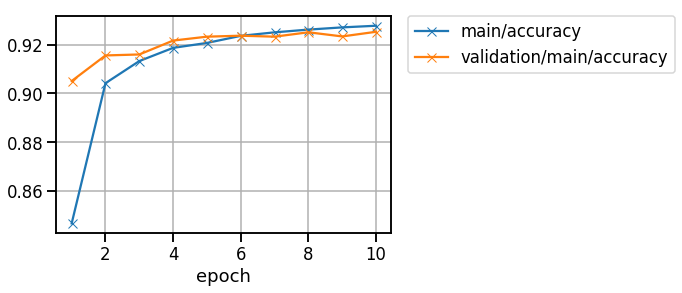

In [22]:
from IPython.display import Image, display_png
display_png(Image('result/lossG.png'))
display_png(Image('result/accuracyG.png'))

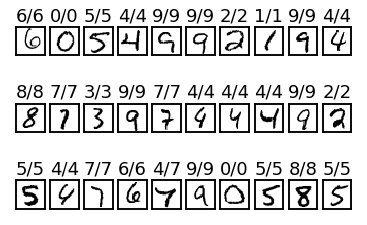

In [23]:
# 識別結果の確認（Chainer cuda版）
images = np.array([image for (image,label) in testC[100:130]])
imagesG = cuda.cupy.array(images)
labels = cuda.cupy.array([label for (image,label) in testC[100:130]])
predict = [cuda.cupy.argmax(x) for x in modelG.predictor(imagesG).data]
plotchr2(images,predict,labels,categorical=False)

# MNISTの手書き文字データの学習と識別　CNN編　へとつづく

# TensorFlow 